In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

## 1. Ознакомление с данными 

Загружаем данные:

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

### 1.1. Смотрим общую информацию и чистим данные.

Начинаем с пользователей тарифных планов

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
print("Число строк в датафрейме users:", users.shape[0])
print("Число уникальных пользователей:", users['user_id'].count())
print("Число дубликатов:", users.duplicated().sum())

Число строк в датафрейме users: 500
Число уникальных пользователей: 500
Число дубликатов: 0


Все пользователи уникальные, дубликатов нет.
Посмотрим на пропуски:

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
users[['reg_date', 'churn_date']].describe()

,reg_date,churn_date
count,500,38
unique,270,33
top,2018-05-28,2018-12-03
freq,8,2


Пропуски только в столбце churn_date, причем их довольно много. Смотрим описание задачи - там сказано:
churn_date дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)".
Вот и хорошо, оставим данные в этом столбце как есть - для решения поставленной задачи они нам не нужны. 
Так последняя дата прекращения пользования была на 09.12.2018г оцениваем анализ в рамках 2018 года.

reg_date в последующем поменяем на datatime

Посмотрим таблицу calls:

In [7]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Данные полные, без пропусков.

Построим гистограмму распределения звонков

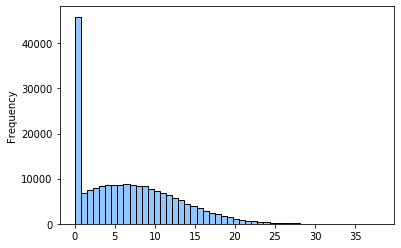

In [9]:
plt.style.use('seaborn-pastel')
calls['duration'].plot(kind='hist', ec='black', bins=50)

Можем быть, все звонки длительностью до 1 минуты, имеют длительность "0"? Проверяем:

In [10]:
calls.query('duration == 0')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
9,1000_9,2018-08-15,0.0,1000
...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499
202592,1499_205,2018-10-13,0.0,1499
202593,1499_206,2018-12-26,0.0,1499
202594,1499_207,2018-10-28,0.0,1499


Проверим к одному ли тарифу они относятся. 

In [11]:
map_to_fill_tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
calls['Тариф'] = calls['user_id'].map(map_to_fill_tariff)
calls['Тариф'].value_counts()

smart    130315
ultra     72292
Name: Тариф, dtype: int64

В каждом из тарифов есть нулевые звонки. Похоже это звонки не соотоявшиеся (был абонент занят или не доступен). Т.к. они не участвуют в тарификации звонко, то мы их удаляем.

In [12]:
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()

Т.к. тарификация по минутная, то округляем в большую сторону. Приводим продлжительность звонков до целых минут. И посмотрим результат.

In [13]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls.head()

,id,call_date,duration,user_id,Тариф
2,1000_2,2018-06-11,3.0,1000,ultra
3,1000_3,2018-09-21,14.0,1000,ultra
4,1000_4,2018-12-15,6.0,1000,ultra
7,1000_7,2018-08-22,19.0,1000,ultra
8,1000_8,2018-09-15,19.0,1000,ultra


Построим заново гистограмму

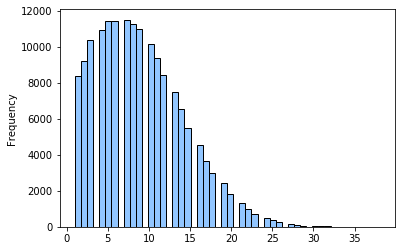

In [14]:
calls['duration'].plot(kind='hist', ec='black', bins=50)

Посмотрим таблицу internet:

In [15]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Данные полные, без пропусков.

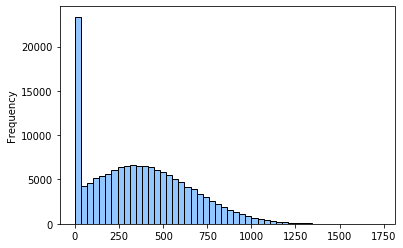

In [17]:
internet['mb_used'].plot(kind='hist', ec='black', bins=50)

In [18]:
internet.query('mb_used == 0')

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


Строки с нулевыми значениями так же сключаем. Интернет соединение не было осуществленно.

In [19]:
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()

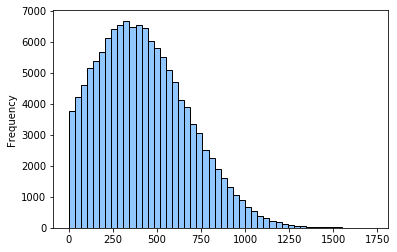

In [20]:
internet['mb_used'].plot(kind='hist', ec='black', bins=50)

Посмотрим таблицу tariffs:

In [21]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Это справочная информация и данные по ней полностью заполнены.

### 1.2. Самые популярные города клиентов.

Посмотрим, какие города представлены в этом датафрейме и в каком процентном соотношении:

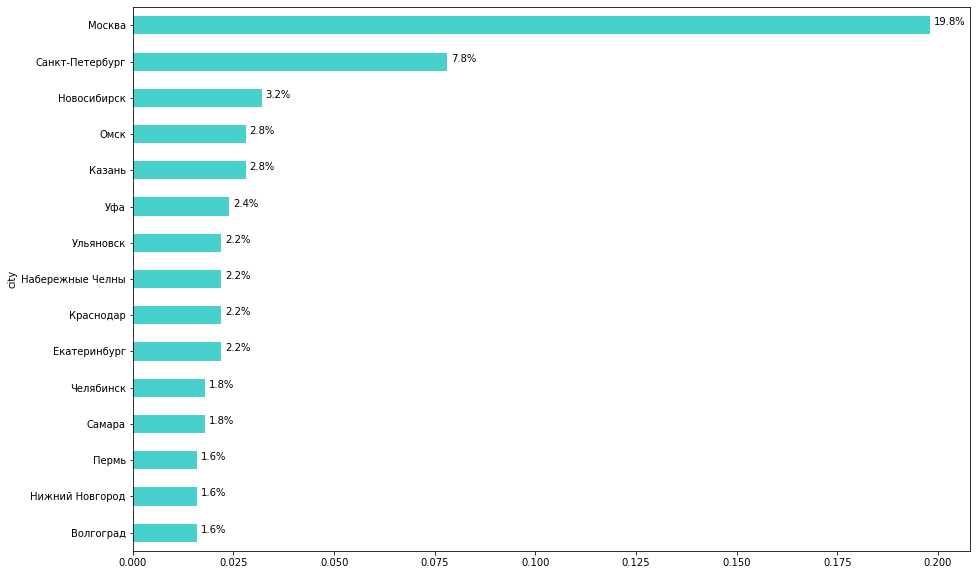

In [22]:
all_users = len(users)
df_sity_top = users.groupby('city').size()/all_users
df_sity_top_filter = df_sity_top[df_sity_top > 0.015].sort_values()
ax = df_sity_top_filter.plot(kind='barh', color='#48D1CC', figsize=(15,10))
for i, v in enumerate(df_sity_top_filter):
    ax.text(v + 0.001, i, "{:.1%}".format(v), color='black')

#labels = dict(df_sity_top_filter)
#labels

Больше всего клиентов в этом датафрейме из Москвы (почти 20%) и из Питера (7,8%).
Представителей остальных городов от 3,2% и меньше (условно их назовем - Регионы).

Изменения формата столбца на datetime и добавление столбцов "месяц" и "время года":

In [23]:
# функция определения времени года
def season(date):
    if date.month in [1, 2, 12]:
        return 'зима'
    elif date.month in [3, 4, 5]:
        return 'весна'
    elif date.month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

    
# столбец в формат datetime + добавление столбцов "месяц" и "время года"
def date_month_season(dataframes):
    for df in dataframes:
        for column in df.columns:
            if 'date' in column and column != 'churn_date':
                df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
                df['месяц'] = df[column].apply(lambda x: x.month)
                df['время года'] = df[column].apply(season)

In [24]:
date_month_season([users, calls, messages, internet])

In [25]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,месяц,время года
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,весна
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,осень
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,лето
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,лето
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,весна


In [26]:
calls.head()

,id,call_date,duration,user_id,Тариф,месяц,время года
2,1000_2,2018-06-11,3.0,1000,ultra,6,лето
3,1000_3,2018-09-21,14.0,1000,ultra,9,осень
4,1000_4,2018-12-15,6.0,1000,ultra,12,зима
7,1000_7,2018-08-22,19.0,1000,ultra,8,лето
8,1000_8,2018-09-15,19.0,1000,ultra,9,осень


Посмотрим на то, каким типом связи (звонок, отправка СМС, выход в интернет) пользуются чаще всего (по месяцам)

In [27]:
def barplot_month(dfs):
    list_dfs = dfs
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    
    list_colors = ['chartreuse', 'blue', 'orange']

    dfs_names_for_legend = ['Количество звонков', 'Количество отпр.СМС', 'Количество интернет-сессий']
    legend_list = []

    for i in range(len(list_dfs)):
        month_df = list_dfs[i]
        month_df_id = month_df.groupby('месяц')['id'].count().reset_index()
        plot = month_df_id.plot(x='месяц', y='id', kind='bar', ec='black', color=list_colors[i],
                                ax=ax, width=0.12, position=i)
        legend_list.append(dfs_names_for_legend[i])
    plt.xticks(rotation=0)
    ax.legend(legend_list)

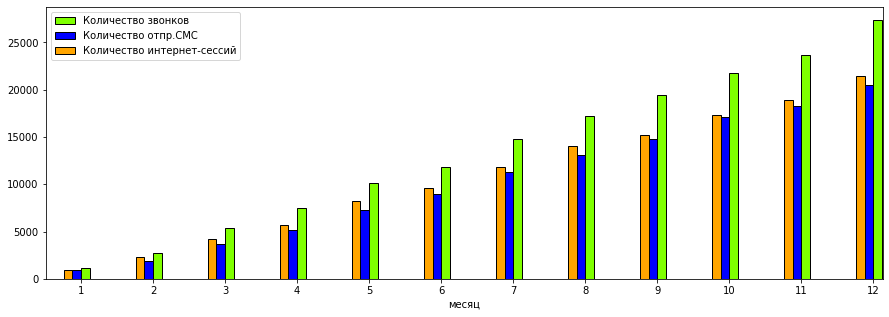

In [28]:
barplot_month([calls, messages, internet])

Клиенты чаще звонят и реже всего отправляют СМС.

In [29]:
def barplot_month2(dfs, query=None):
    list_dfs = dfs
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    
    list_colors = ['forestgreen']

    dfs_names_for_legend = ['Продолжительность звонков']
    legend_list = []

    for i in range(len(list_dfs)):
        month_df = list_dfs[i]
        if query == None:
            month_df_id = month_df.groupby('месяц')['duration'].sum().reset_index()
        else:
            month_df_id = month_df.query(query).groupby('месяц')['duration'].sum().reset_index()
        
        plot = month_df_id.plot(x='месяц', y='duration', kind='bar', ec='black', color=list_colors[i],
                                ax=ax, width=0.12, position=i)
        legend_list.append(dfs_names_for_legend[i])
    plt.xticks(rotation=0)
    ax.legend(legend_list)

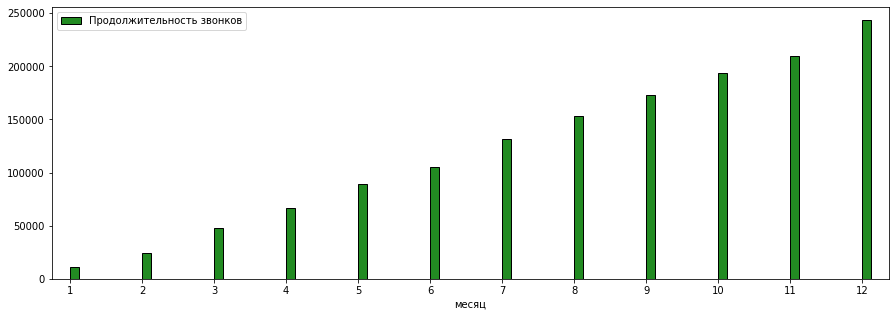

In [30]:
barplot_month2([calls])

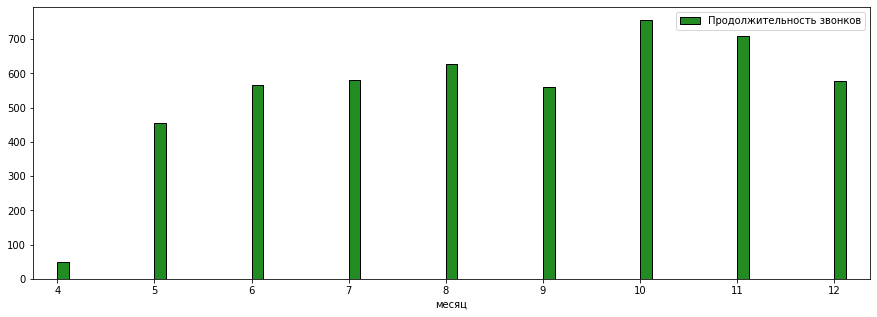

In [31]:
barplot_month2([calls], query='user_id == 1200')

### Продолжительность по месяцам звонков растет, все логично больше звонков, следовательно, больше и продолжительность. Похоже оператор с данными тарифами только вышел на рынок. Проверили данную версию выборочно на нескольких клиентах. Все верно, так и есть.

## 2. Расчёт помесячной выручки с каждого пользователя:

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Для начала возьмем из каждого имеющегося датафрейма нужную информацию и склеим эти данные в один датафрейм. Т.к. тарификация по 1 Гб в тарифных планах, то округлим до данных величин.

In [32]:
user_of_calls = calls.groupby(['user_id', 'время года', 'месяц'])['duration'].agg(['count', 'sum'])
user_of_messages = messages.groupby(['user_id', 'время года', 'месяц'])['id'].count()
user_of_internet = (internet.groupby(['user_id', 'время года', 'месяц'])\
                   .sum()['mb_used']/1024).apply(np.ceil)


In [33]:
#Проверили все значения
user_of_calls.head(10)

count    sum
user_id время года месяц              
1000    весна      5         17  159.0
        зима       12        38  333.0
        лето       6         28  172.0
                   7         41  340.0
                   8         42  408.0
        осень      9         46  466.0
                   10        44  350.0
                   11        37  338.0
1001    зима       12        47  414.0
        осень      11        45  430.0

In [34]:
df_numbers = pd.concat([user_of_calls, user_of_messages, user_of_internet], axis=1)
df_numbers = df_numbers.reset_index()
df_numbers.columns = ['user_id', 'время года', 'Месяц', 'Кол-во звонков, шт.', 'Звонки, мин.',
                      'СМС, шт.', 'Интернет, Гб']
df_numbers.head()

,user_id,время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Гб"
0,1000,весна,5,17.0,159.0,22.0,3.0
1,1000,зима,12,38.0,333.0,70.0,10.0
2,1000,лето,6,28.0,172.0,60.0,23.0
3,1000,лето,7,41.0,340.0,75.0,14.0
4,1000,лето,8,42.0,408.0,81.0,14.0


Добавим столбцы с тарифом и городом

In [35]:
user_of_tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
df_numbers['Тариф'] = df_numbers['user_id'].map(user_of_tariff)

user_of_city = dict(pd.Series(users['city'].values, index=users['user_id']))
df_numbers['Город'] = df_numbers['user_id'].map(user_of_city)

In [36]:
df_numbers.columns = ['User_id', 'Время года', 'Месяц', 'Кол-во звонков, шт.', 'Звонки, мин.',
                      'СМС, шт.', 'Интернет, Гб', 'Тариф', 'Город']

In [37]:
df_numbers.sort_values(by=['User_id', 'Месяц']).head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Гб",Тариф,Город
0,1000,весна,5,17.0,159.0,22.0,3.0,ultra,Краснодар
2,1000,лето,6,28.0,172.0,60.0,23.0,ultra,Краснодар
3,1000,лето,7,41.0,340.0,75.0,14.0,ultra,Краснодар
4,1000,лето,8,42.0,408.0,81.0,14.0,ultra,Краснодар
5,1000,осень,9,46.0,466.0,57.0,15.0,ultra,Краснодар
6,1000,осень,10,44.0,350.0,73.0,15.0,ultra,Краснодар
7,1000,осень,11,37.0,338.0,58.0,15.0,ultra,Краснодар
1,1000,зима,12,38.0,333.0,70.0,10.0,ultra,Краснодар
9,1001,осень,11,45.0,430.0,NaN,18.0,smart,Москва
8,1001,зима,12,47.0,414.0,NaN,14.0,smart,Москва


In [38]:
df_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 9 columns):
User_id                3214 non-null int64
Время года             3214 non-null object
Месяц                  3214 non-null int64
Кол-во звонков, шт.    3168 non-null float64
Звонки, мин.           3168 non-null float64
СМС, шт.               2717 non-null float64
Интернет, Гб           3201 non-null float64
Тариф                  3214 non-null object
Город                  3214 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 226.1+ KB


In [39]:
df_numbers[df_numbers['Интернет, Гб'].isnull()]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Гб",Тариф,Город
592,1094,весна,5,12.0,107.0,3.0,NaN,ultra,Новосибирск
1722,1273,весна,5,19.0,220.0,21.0,NaN,ultra,Курган
1723,1273,зима,12,38.0,260.0,39.0,NaN,ultra,Курган
1724,1273,лето,6,28.0,230.0,38.0,NaN,ultra,Курган
1725,1273,лето,7,30.0,253.0,37.0,NaN,ultra,Курган
1726,1273,лето,8,39.0,253.0,41.0,NaN,ultra,Курган
1727,1273,осень,9,28.0,223.0,32.0,NaN,ultra,Курган
1728,1273,осень,10,35.0,315.0,35.0,NaN,ultra,Курган
1729,1273,осень,11,31.0,272.0,29.0,NaN,ultra,Курган
2307,1365,осень,10,5.0,43.0,1.0,NaN,smart,Ростов-на-Дону


Заполнение пропусков:

Пропуски есть по каждому из столбцов. Вероятно, некоторые из пользователей за рассматриваемый период времени или ни разу не звонили, или ни разу не отправляли СМС, или ни разу не выходили в интернет. Посмотрим, нет ли у нас пользователей, которые ни разу не звонили, не отправляли смс и не заходили в интернет:

In [40]:
df_numbers[(df_numbers['Интернет, Гб'].isnull()) & (df_numbers['СМС, шт.'].isnull())
           & (df_numbers['Звонки, мин.'].isnull())]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Гб",Тариф,Город


Таких нет, это значит, что каждый из пользователей активный, просто в какие-то периоды мог не пользоваться одним из типов связи.

Поэтому проставим по имеющимся пропускам нули, которые будут означать, что в конкретном месяце данный клиент не звонил/не отправлял СМС/не пользовался интернетом:

In [41]:
df_numbers = df_numbers.fillna(0)

In [42]:
df_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 9 columns):
User_id                3214 non-null int64
Время года             3214 non-null object
Месяц                  3214 non-null int64
Кол-во звонков, шт.    3214 non-null float64
Звонки, мин.           3214 non-null float64
СМС, шт.               3214 non-null float64
Интернет, Гб           3214 non-null float64
Тариф                  3214 non-null object
Город                  3214 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 226.1+ KB


Все пропуски заполнены

## Проведем анализ по тарифным планам

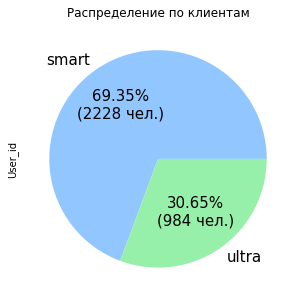

In [43]:
all_users = df_numbers['User_id'].count()

def func_pct(pct):
    value = int(pct/100.*all_users)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

axes = df_numbers.groupby('Тариф')['User_id'].count().plot(kind='pie', fontsize=15,
                                                           title = 'Распределение по клиентам',
                                                           figsize=(20,5),
                                                           autopct=lambda pct: func_pct(pct))

ax.legend(['Смарт', 'Ультра'], prop={'size':20})

### Почти 70% клиентов предпочитают тарифный план Смарт
И основная причина, так как он изначально дешевле.

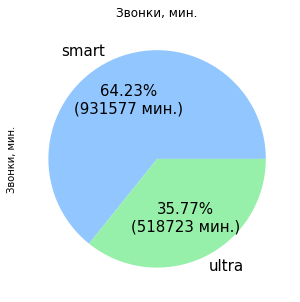

In [44]:
calls_sum = df_numbers['Звонки, мин.'].sum()

def func_pct(pct):
    value = int(pct/100.*calls_sum)
    return "{:.2f}%\n({:.0f} мин.)".format(pct, value)

axes = df_numbers.groupby('Тариф')['Звонки, мин.'].sum().plot(kind='pie', fontsize=15, 
                                                              title = 'Звонки, мин.', figsize=(20,5),
                                                              autopct=lambda pct: func_pct(pct))

ax.legend(['Смарт', 'Ультра'], prop={'size':20})

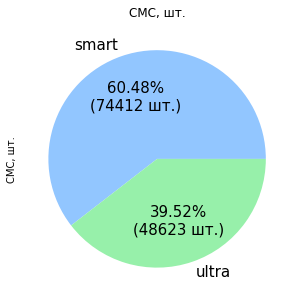

In [45]:
calls_sum = df_numbers['СМС, шт.'].sum()

def func_pct(pct):
    value = int(pct/100.*calls_sum)
    return "{:.2f}%\n({:.0f} шт.)".format(pct, value)

axes = df_numbers.groupby('Тариф')['СМС, шт.'].sum().plot(kind='pie', fontsize=15, 
                                                              title = 'СМС, шт.', figsize=(20,5),
                                                              autopct=lambda pct: func_pct(pct))

ax.legend(['Смарт', 'Ультра'], prop={'size':20})

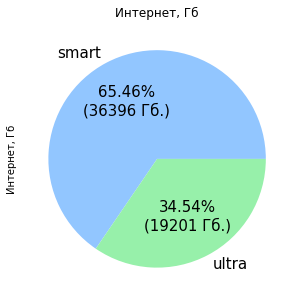

In [46]:
calls_sum = df_numbers['Интернет, Гб'].sum()

def func_pct(pct):
    value = int(pct/100.*calls_sum)
    return "{:.2f}%\n({:.0f} Гб.)".format(pct, value)

axes = df_numbers.groupby('Тариф')['Интернет, Гб'].sum().plot(kind='pie', fontsize=15, 
                                                              title = 'Интернет, Гб', figsize=(20,5),
                                                              autopct=lambda pct: func_pct(pct))

ax.legend(['Смарт', 'Ультра'], prop={'size':20})

### Следовательно, т.к. клиенты изначально предпочитают тарифный план Смарт, то и количество звонков, СМС и Интернета больше используется на данном тарифном плане.

Добавление информации о помесячной выручке с каждого пользователя:
Разобьем на 3 группы столбцов:

- "Абон. плата";
- "Минуты сверх", "СМС сверх", "Мб сверх", "Плата сверх лимита";
- "Сумма за месяц".

In [47]:
month_price = {'smart': 550, 'ultra': 1950}
df_numbers['Абон. плата, руб.'] = df_numbers['Тариф'].map(month_price)

Для создания столбцов "Минуты сверх", "СМС сверх", "Мб сверх", "Плата сверх лимита" напишем функцию, которая будет считать превышения в зависимости от тарифа:

In [48]:
df_numbers.head()

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Гб",Тариф,Город,"Абон. плата, руб."
0,1000,весна,5,17.0,159.0,22.0,3.0,ultra,Краснодар,1950
1,1000,зима,12,38.0,333.0,70.0,10.0,ultra,Краснодар,1950
2,1000,лето,6,28.0,172.0,60.0,23.0,ultra,Краснодар,1950
3,1000,лето,7,41.0,340.0,75.0,14.0,ultra,Краснодар,1950
4,1000,лето,8,42.0,408.0,81.0,14.0,ultra,Краснодар,1950


In [49]:
def calls_not_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Звонки, мин.'] - 500
        return np.where(result > 0, result, 0)
    else:
        result = row['Звонки, мин.'] - 3000
        return np.where(result > 0, result, 0)
    
    
def sms_not_plan(row):
    if row['Тариф'] == 'smart':
        result = row['СМС, шт.'] - 50
        return np.where(result > 0, result, 0)
    else:
        result =  row['СМС, шт.'] - 1000
        return np.where(result > 0, result, 0)
    

def internet_not_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Интернет, Гб'] - 15
        return np.where(result > 0, result, 0)
    else:
        result = row['Интернет, Гб'] - 30
        return np.where(result > 0, result, 0)
    
    
def month_total(row):
    sum_per_month = 0
    if row['Тариф'] == 'smart':
        sum_per_month += np.ceil(row['Минуты сверх']) * 3
        sum_per_month += row['СМС сверх'] * 3
        sum_per_month += np.ceil(row['Гб сверх']) * 200
        return sum_per_month
    
    else:
        sum_per_month += np.ceil(row['Минуты сверх']) * 1
        sum_per_month += row['СМС сверх'] * 1
        sum_per_month += np.ceil(row['Гб сверх']) * 150
        return sum_per_month

Создадим новые столбцы:

In [50]:
df_numbers['Минуты сверх'] = df_numbers.apply(calls_not_plan, axis=1)
df_numbers['СМС сверх'] = df_numbers.apply(sms_not_plan, axis=1)
df_numbers['Гб сверх'] = df_numbers.apply(internet_not_plan, axis=1)

df_numbers['Плата сверх лимита, руб.'] = df_numbers.apply(month_total, axis=1)

for column in ['Минуты сверх', 'Гб сверх']:
    df_numbers[column] = df_numbers[column].astype('float')

for column in ['СМС сверх', 'Плата сверх лимита, руб.']:
    df_numbers[column] = df_numbers[column].astype('int')

In [51]:
df_numbers.head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Гб",Тариф,Город,"Абон. плата, руб.",Минуты сверх,СМС сверх,Гб сверх,"Плата сверх лимита, руб."
0,1000,весна,5,17.0,159.0,22.0,3.0,ultra,Краснодар,1950,0.0,0,0.0,0
1,1000,зима,12,38.0,333.0,70.0,10.0,ultra,Краснодар,1950,0.0,0,0.0,0
2,1000,лето,6,28.0,172.0,60.0,23.0,ultra,Краснодар,1950,0.0,0,0.0,0
3,1000,лето,7,41.0,340.0,75.0,14.0,ultra,Краснодар,1950,0.0,0,0.0,0
4,1000,лето,8,42.0,408.0,81.0,14.0,ultra,Краснодар,1950,0.0,0,0.0,0
5,1000,осень,9,46.0,466.0,57.0,15.0,ultra,Краснодар,1950,0.0,0,0.0,0
6,1000,осень,10,44.0,350.0,73.0,15.0,ultra,Краснодар,1950,0.0,0,0.0,0
7,1000,осень,11,37.0,338.0,58.0,15.0,ultra,Краснодар,1950,0.0,0,0.0,0
8,1001,зима,12,47.0,414.0,0.0,14.0,smart,Москва,550,0.0,0,0.0,0
9,1001,осень,11,45.0,430.0,0.0,18.0,smart,Москва,550,0.0,0,3.0,600


Для создания столбца "Сумма за месяц" построчно просуммируем данные по 2 только что созданным столбцам: "Абон. плата" и "Плата сверх лимита":

In [52]:
df_numbers['Сумма за месяц, руб.'] = (df_numbers['Абон. плата, руб.']
                                      + df_numbers['Плата сверх лимита, руб.']).copy()

In [53]:
df_numbers.head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Гб",Тариф,Город,"Абон. плата, руб.",Минуты сверх,СМС сверх,Гб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб."
0,1000,весна,5,17.0,159.0,22.0,3.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
1,1000,зима,12,38.0,333.0,70.0,10.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
2,1000,лето,6,28.0,172.0,60.0,23.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
3,1000,лето,7,41.0,340.0,75.0,14.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
4,1000,лето,8,42.0,408.0,81.0,14.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
5,1000,осень,9,46.0,466.0,57.0,15.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
6,1000,осень,10,44.0,350.0,73.0,15.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
7,1000,осень,11,37.0,338.0,58.0,15.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
8,1001,зима,12,47.0,414.0,0.0,14.0,smart,Москва,550,0.0,0,0.0,0,550
9,1001,осень,11,45.0,430.0,0.0,18.0,smart,Москва,550,0.0,0,3.0,600,1150


Посмотрим, есть ли вообще клиенты, которые превышали лимиты:

In [54]:
df_numbers[df_numbers['Сумма за месяц, руб.'] > 1950]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Гб",Тариф,Город,"Абон. плата, руб.",Минуты сверх,СМС сверх,Гб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб."
68,1009,лето,7,20.0,183.0,14.0,25.0,smart,Пермь,550,0.0,0,10.0,2000,2550
69,1009,лето,8,27.0,249.0,9.0,24.0,smart,Пермь,550,0.0,0,9.0,1800,2350
81,1011,зима,12,44.0,361.0,6.0,23.0,smart,Самара,550,0.0,0,8.0,1600,2150
87,1011,осень,11,52.0,501.0,12.0,25.0,smart,Самара,550,1.0,0,10.0,2003,2553
90,1012,весна,5,35.0,316.0,10.0,26.0,smart,Санкт-Петербург,550,0.0,0,11.0,2200,2750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3199,1496,лето,8,62.0,527.0,41.0,23.0,smart,Вологда,550,27.0,0,8.0,1681,2231
3200,1496,осень,9,58.0,486.0,29.0,27.0,smart,Вологда,550,0.0,0,12.0,2400,2950
3201,1496,осень,10,56.0,450.0,35.0,28.0,smart,Вологда,550,0.0,0,13.0,2600,3150
3202,1496,осень,11,66.0,662.0,46.0,25.0,smart,Вологда,550,162.0,0,10.0,2486,3036


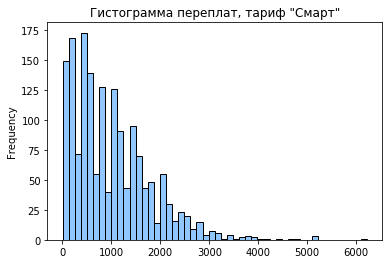

In [55]:
title = 'Гистограмма переплат, тариф "Смарт"'
df_pay = df_numbers[(df_numbers['Тариф'] == 'smart') & (df_numbers['Плата сверх лимита, руб.'] > 0)]\
['Плата сверх лимита, руб.']
df_pay.plot(kind='hist', title=title, ec='black', bins=50)

Большинство переплачивает до 1200 рублей. Это довольно много, учитывая, что размер абонентский платы - 550 рублей.
Посмотрим ближе:

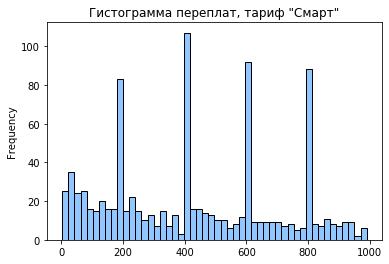

In [56]:
title = 'Гистограмма переплат, тариф "Смарт"'
df_pay_1200 = df_numbers[(df_numbers['Тариф'] == 'smart')& (df_numbers['Плата сверх лимита, руб.'] > 0) & (df_numbers['Плата сверх лимита, руб.'] < 1000)]['Плата сверх лимита, руб.']
df_pay_1200.plot(kind='hist', title=title, ec='black', bins=50)

### Как видно переплаты кратны 200 руб. Похоже переплаты больше связаны с интернетом (1Гб интернета = 200 рублей)

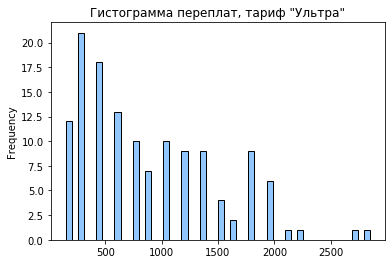

In [57]:
title = 'Гистограмма переплат, тариф "Ультра"'
df_pay = df_numbers[(df_numbers['Тариф'] == 'ultra') & (df_numbers['Плата сверх лимита, руб.'] > 0)]['Плата сверх лимита, руб.']
df_pay.plot(kind='hist', title=title, ec='black', bins=50)

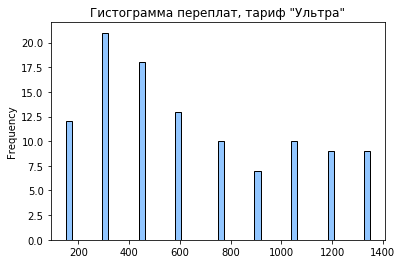

In [58]:
title = 'Гистограмма переплат, тариф "Ультра"'
df_pay_1500 = df_numbers[(df_numbers['Тариф'] == 'ultra') & 
                                  (df_numbers['Плата сверх лимита, руб.'] > 0) &
                                  (df_numbers['Плата сверх лимита, руб.'] < 1500)]['Плата сверх лимита, руб.']
df_pay_1500.plot(kind='hist', title=title, ec='black', bins=50)

### Как же переплаты связаны с интернетом (1Гб интернета = 150 рублей)

In [59]:
df_numbers.groupby('Тариф').sum()[['Минуты сверх', 'СМС сверх', 'Гб сверх']]

,Минуты сверх,СМС сверх,Гб сверх
Тариф,,,
smart,92739.0,12928,6662.0
ultra,0.0,0,789.0


Пользователи Смарта дозаказывают не только интернет-трафик, но и минуты и СМС. Так как тарифный план Смарт более бюджетный.

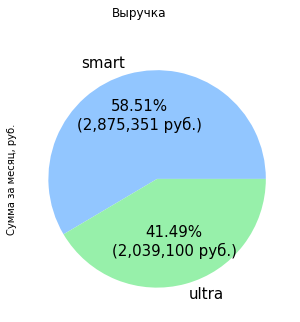

In [60]:
all_revenue = df_numbers['Сумма за месяц, руб.'].sum()

def func_pct(pct):
    value = float(pct/100.*all_revenue)
    return "{:.2f}%\n({:,.0f} руб.)".format(pct, value)

axes = df_numbers.groupby('Тариф')['Сумма за месяц, руб.'].sum().plot(kind='pie', subplots=True,
                                                                      fontsize=15, title = 'Выручка',
                                                                      figsize=(20,5), autopct=lambda
                                                                      pct: func_pct(pct))

ax.legend(['Смарт', 'Ультра'], prop={'size':12})

### Выручки приносит больше тарифный план Смарт (больше клиентов, больше и выручка). Хотя клиентов Смарта 70%, а выручка по плану Смарт только 58%.

## 3. Описание поведения клиента на основе полученной выборки

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

### Получаем информацию о выбросах по каждому из набора данных.

Сначала построим boxplot'ы по всем рассматриваемым данным (длительность звонка, количество отправленных СМС, объем использованного интернет-трафика).
Напишем под это функцию:

In [61]:
df_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 15 columns):
User_id                     3214 non-null int64
Время года                  3214 non-null object
Месяц                       3214 non-null int64
Кол-во звонков, шт.         3214 non-null float64
Звонки, мин.                3214 non-null float64
СМС, шт.                    3214 non-null float64
Интернет, Гб                3214 non-null float64
Тариф                       3214 non-null object
Город                       3214 non-null object
Абон. плата, руб.           3214 non-null int64
Минуты сверх                3214 non-null float64
СМС сверх                   3214 non-null int64
Гб сверх                    3214 non-null float64
Плата сверх лимита, руб.    3214 non-null int64
Сумма за месяц, руб.        3214 non-null int64
dtypes: float64(6), int64(6), object(3)
memory usage: 376.8+ KB


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

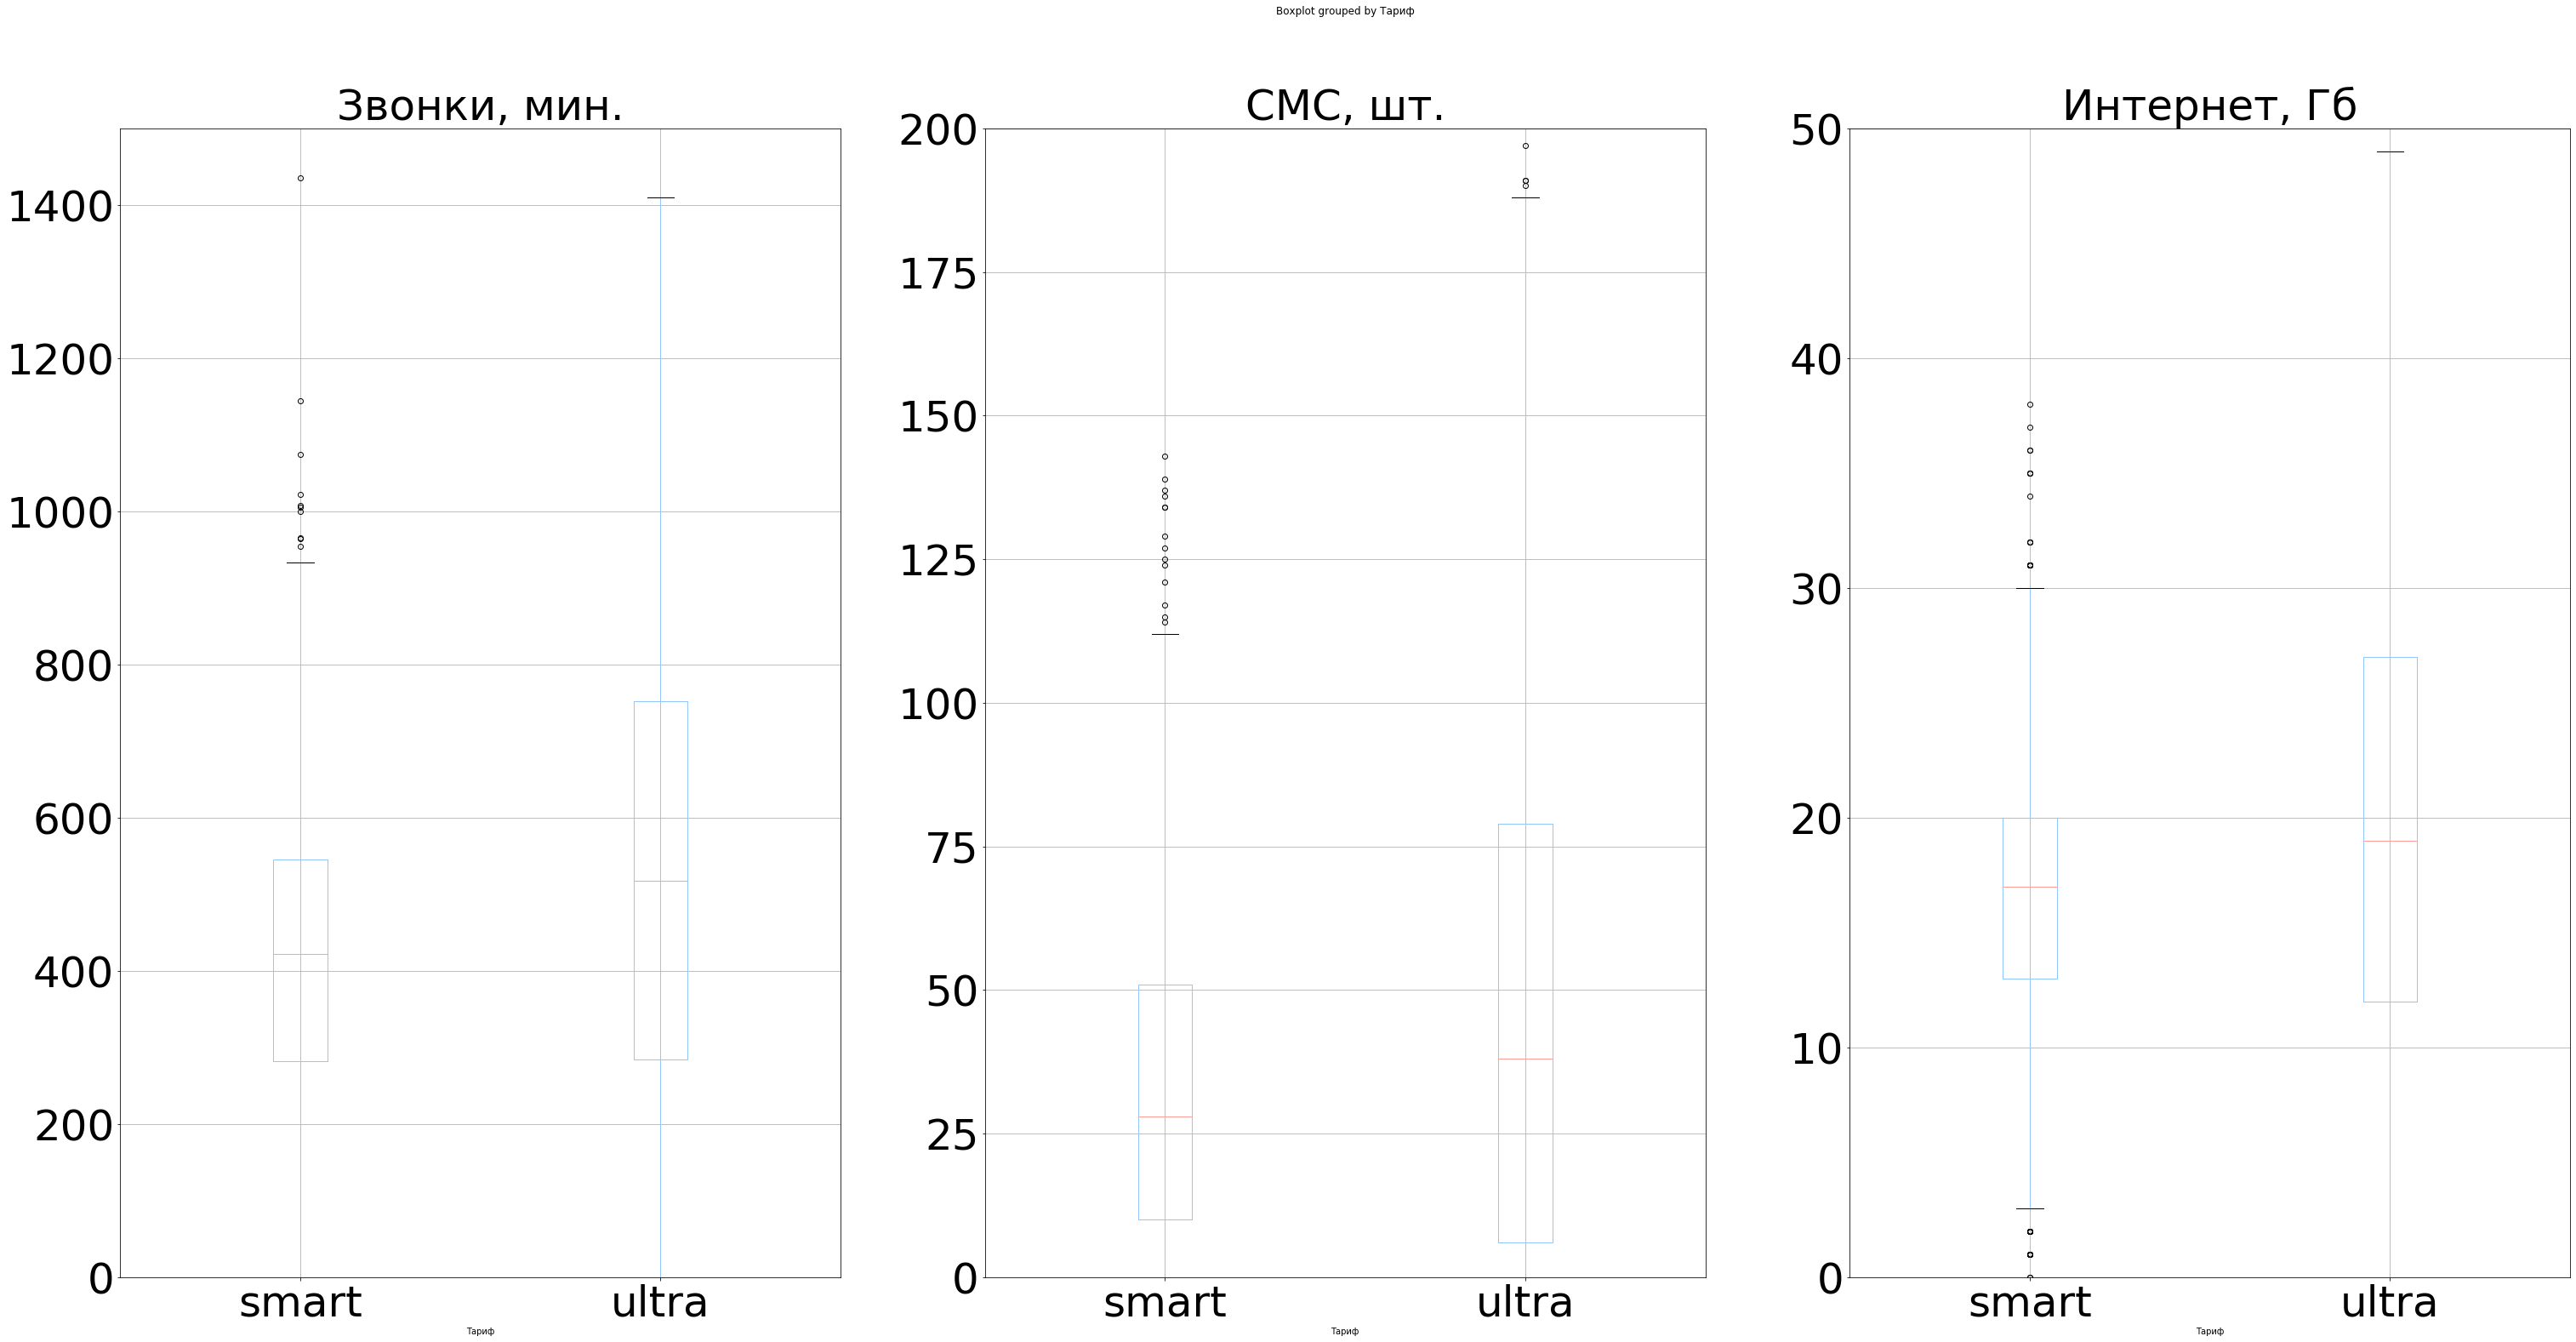

In [62]:
rows = 1
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(50,25))
column_list = ['Звонки, мин.', 'СМС, шт.', 'Интернет, Гб']
ylims = [1500, 200, 50]
count = 0
for r in range(rows):
    for c in range(cols):
        ax = df_numbers.boxplot(column=column_list[count], by='Тариф', fontsize=50, ax=axes[c])
        ax.title.set_size(50)
        ax.set_ylim([0, ylims[count]])
        count += 1            

In [63]:
calls_smart_min = 0
calls_smart_max = 930
calls_ultra_min = 0
calls_ultra_max = 1410

sms_smart_min = 0
sms_smart_max = 110
sms_ultra_min = 0
sms_ultra_max = 185

internet_smart_min = 3
internet_smart_max = 32
internet_ultra_min = 0
internet_ultra_max = 48

In [64]:
def plot_hist_comparison(data):
    
    ax = plt.gca()
    func_dict = {'Звонки': 'Звонки, мин.', 'СМС': 'СМС, шт.', 'Интернет': 'Интернет, Гб'}
    xlims = [(calls_smart_min, calls_smart_max), (calls_ultra_min, calls_ultra_max),
             (sms_smart_min, sms_smart_max), (sms_ultra_min, sms_ultra_max),
             (internet_smart_min, internet_smart_max), (internet_ultra_min, internet_ultra_max)]
    
    filt_column = func_dict[data]

    # оформление в зависимости от рассматриваемых данных
    if data == 'Звонки':
        title = 'Гистограмма длительности звонков, мин.'
        xlim1 = xlims[0]
        xlim2 = xlims[1]
        text_x = (58, 8)
        text_y = 112

    elif data == 'СМС':
        title = 'Гистограмма количества отправленных СМС, шт.'
        xlim1 = xlims[2]
        xlim2 = xlims[3]
        text_x = (5.5, 1)
        text_y = 350

    else :
        title = 'Гистограмма количества использованного интернет-трафика, Гб'
        xlim1 = xlims[4]
        xlim2 = xlims[5]
        text_x = (2.0, 0.8)
        text_y = 140
    
    # получаем отфильтрованные от выбросов датафреймы
    filter_smart_data = df_numbers[(df_numbers['Тариф'] == 'smart') &
                                   (df_numbers[filt_column] >= xlim1[0]) &
                                   (df_numbers[filt_column] <= xlim1[1])][filt_column]
    filter_ultra_data = df_numbers[(df_numbers['Тариф'] == 'ultra') &
                                   (df_numbers[filt_column] >= xlim2[0]) &
                                   (df_numbers[filt_column] <= xlim2[1])][filt_column]
    # рисуем
    filter_smart_data.plot(kind='hist', bins=40, figsize=(12,6), ec='black', ax=ax, color='#4871d1',
                           title=title, xlim=xlim1)
    filter_ultra_data.plot(kind='hist', bins=70, figsize=(12,6), ec='black', ax=ax, color='#48D1CC',
                           title=title, xlim=xlim2)
    
    # расчетные данные
    mean_smart = filter_smart_data.mean()
    mean_ultra = filter_ultra_data.mean()
    # Дисперсия
    disp_smart = filter_smart_data.var() 
    disp_ultra = filter_ultra_data.var()
    # Стандартное отклонение
    std_smart = filter_smart_data.std() 
    std_ultra = filter_ultra_data.std()
    
    if data == 'СМС':
        smart_data = 'Сред.зн. - {:.2f}\nДисперсия - {:.2f}\nСтанд.откл. - {:.2f}'\
        .format(mean_smart, disp_smart, std_smart)
        ultra_data = 'Сред.зн. - {:.2f}\nДисперсия - {:.2f}\nСтанд.откл. - {:.2f}'\
        .format(mean_ultra, disp_ultra, std_ultra)
    else:
        smart_data = 'Сред.зн. - {:.2f}\nДисперсия - {:.2f}\nСтанд.откл. - {:.2f}'\
        .format(mean_smart, disp_smart, std_smart)
        ultra_data = 'Сред.зн. - {:.2f}\nДисперсия - {:.2f}\nСтанд.откл. - {:.2f}'\
        .format(mean_ultra, disp_ultra, std_ultra)
    
    legend_second = plt.legend([smart_data, ultra_data], prop={'size':12}, 
                                framealpha=0, bbox_to_anchor=(1.0,0.32), loc=4)
    
    
    plt.gca().add_artist(legend_second)
    
    # рисуем медианы
    plt.axvline(x=filter_smart_data.median(),linewidth=5, color='#111bab', linestyle='--')
    ax.text(filter_smart_data.median()-text_x[0], text_y, '{0:.0f}'
            .format(filter_smart_data.median()), fontweight='bold', fontsize='large')
    plt.axvline(x=filter_ultra_data.median(),linewidth=5, color='#68e36c', linestyle='--')
    ax.text(filter_ultra_data.median()+text_x[1], text_y, '{0:.0f}'
            .format(filter_ultra_data.median()), fontweight='bold', fontsize='large')
    
    plt.legend(['Медиана Смарт', 'Медиана Ультра', 'Смарт', 'Ультра'], prop={'size':15})

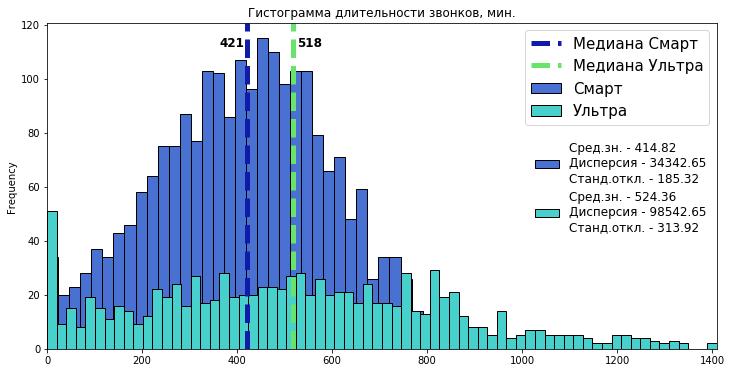

In [65]:
plot_hist_comparison('Звонки')

### В тарифном плане Смарт клиенты в основном разговаривают в течении 250-580 минут. При этом медиана равна 421 минуту (при этом в абонентскую плату включено 500 минут). Клиенты стараются придерживаться объема тарифного плана, хотя порой и выходят за рамки.
### С тарифом Ультра ситуация другая, медиана - 518 минут (при этом в абонентскую плату включено 3000 минут). Большая часть не выговаривает включенные минуты разговора.
### В целом по двум тарифам по продолжительности разговоров клиенты примерно разговаривают одинаково, люди разговаривают сколько им сугубо нужно. Не кто не стремится в тарифном плане Ультра выговорить все заложенные минуты разговора. 

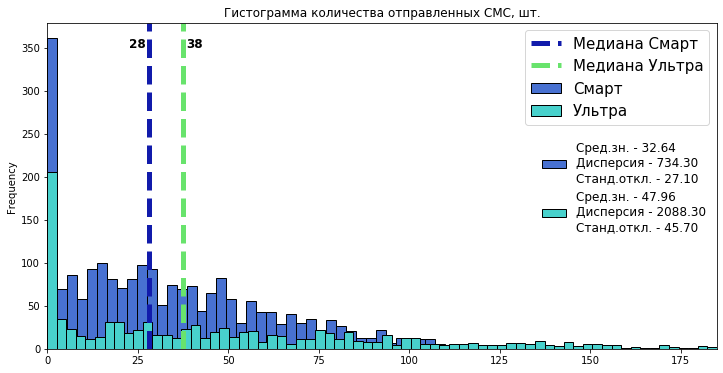

In [66]:
plot_hist_comparison('СМС')

### По обоим тарифам ситуация схожая - большая часть клиентов не отправляет СМС сообщения вообще. Однако, из тех, кто отправляет, большую активность проявляют пользователи тарифа Смарт (значение медианы равно 28 СМС в месяц). Пользователи тарифа Ультра отправляют в среднем до 50 СМС.

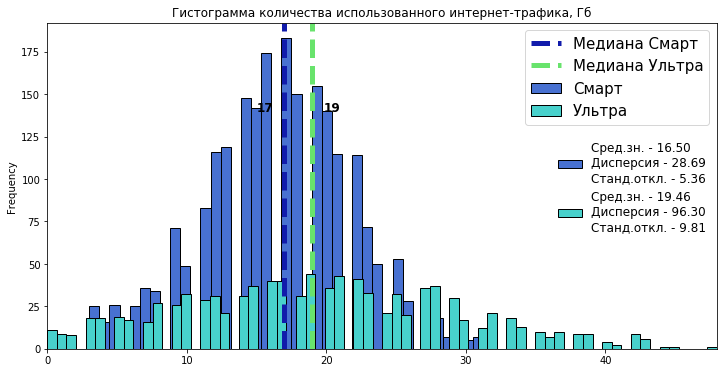

In [67]:
plot_hist_comparison('Интернет')

### Клиенты тарифного плана Смарт в среднем пользуются интернет-трафиком от 14 до 22 Гб (при этом медиана 17Гб). Донным пользователям не хватает заложенного в абоненнской плате интернет-трафика в объеме 15Гб. 
### По тарифному плану Ультра ситуация противоположная. Медиана равна 19Гб, у клиентов есть ощутимый запас по количеству используемого трафика.

## 4. Проверка гипотез

### 4.1 Первая гипотеза о равенстве средних двух совокупностей (среднии выручки клиентов тарифов Смарт и Ультра различаются) 

- H0 (нулевая гипотеза) - предположение о том, что между данными у нас нет связи. В данном случае, что средняя выручка пользователей тарифа <font fontweight='bold'>Смарт</font> не отличается от средней выручки пользователей тарифа <font fontweight='bold'>Ультра</font>.
- H1 (альтернативная гипотеза) - средняя выручка пользователей тарифа Смарт отличается от средней выручки пользователей тарифа Ультра.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, 'Гистограмма по выручке за месяц')

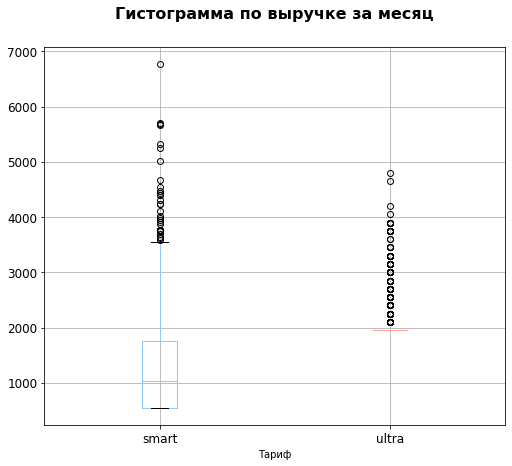

In [68]:
ax = df_numbers.boxplot(column='Сумма за месяц, руб.', by='Тариф', fontsize=12, figsize=(8,7))
ax.set_title('')
ax.title.set_size(40)
plt.suptitle('Гистограмма по выручке за месяц', fontsize=16, fontweight='bold')

### Определим границы интервалов

### Не используем данные определенные границы выбросов в ручную
- Границы интервала для столбца "Сумма за месяц, руб." тарифа "Смарт": 0 - 3500
- Границы интервала для столбца "Сумма за месяц, руб." тарифа "Ультра": 1950

In [69]:
def get_iqr (column, data_filter):
    
    if data_filter == 'Тариф':
        format_name = column
        data1, data2 = 'smart', 'ultra'
        format_end1 = 'тарифа "Смарт"'
        format_end2 = 'тарифа "Ультра"'
    elif data_filter == 'moscow':
        format_name = 'moscow'
        data1, data2 = 0, 1
        format_end1 = 'для регионов'
        format_end2 = 'для Москвы'
    
    quant1_1 = df_numbers[df_numbers[data_filter] == data1][column].quantile(0.25)
    quant3_1 = df_numbers[df_numbers[data_filter] == data1][column].quantile(0.75)
    iqr_1 = quant3_1 - quant1_1
    
    if data_filter == 'moscow':
        min_iqr_1 = np.where( (quant1_1 - 1.5 * iqr_1) > 550, quant1_1 - 1.5 * iqr_1, 550)
    else:
        min_iqr_1 = np.where( (quant1_1 - 1.5 * iqr_1) > 0, quant1_1 - 1.5 * iqr_1, 0)
    
    max_iqr_1 = np.where( (quant3_1 + 1.5 * iqr_1) > 0, quant3_1 + 1.5 * iqr_1, 0)
    
    quant1_2 = df_numbers[df_numbers[data_filter] == data2][column].quantile(0.25)
    quant3_2 = df_numbers[df_numbers[data_filter] == data2][column].quantile(0.75)
    iqr_2 = quant3_2 - quant1_2
    
    if data_filter == 'moscow':
        min_iqr_2 = np.where( (quant1_2 - 1.5 * iqr_2) > 550, quant1_2 - 1.5 * iqr_2, 550)
    else:
        min_iqr_2 = np.where( (quant1_2 - 1.5 * iqr_2) > 0, quant1_2 - 1.5 * iqr_2, 0)
    
    max_iqr_2 = np.where( (quant3_2 + 1.5 * iqr_2) > 0, quant3_2 + 1.5 * iqr_2, 0)
       
    print('Границы интервала для столбца "{}" {}: {} - {}'.format(column, 
                                                                  format_end1, min_iqr_1, max_iqr_1))
    print('Границы интервала для столбца "{}" {}: {} - {}'.format(column,
                                                                  format_end2, min_iqr_2, max_iqr_2))
    
    return (min_iqr_1, max_iqr_1), (min_iqr_2, max_iqr_2)

In [70]:
smart_get_iqr, ultra_get_iqr = get_iqr('Сумма за месяц, руб.', 'Тариф')

Границы интервала для столбца "Сумма за месяц, руб." тарифа "Смарт": 0.0 - 3550.0
Границы интервала для столбца "Сумма за месяц, руб." тарифа "Ультра": 1950.0 - 1950.0


In [71]:
smart_mean_doxod = df_numbers[(df_numbers['Тариф'] == 'smart') &
                              (df_numbers['Сумма за месяц, руб.'] >= smart_get_iqr[0]) &
                              (df_numbers['Сумма за месяц, руб.']
                               <= smart_get_iqr[1])]['Сумма за месяц, руб.']

ultra_mean_doxod = df_numbers[(df_numbers['Тариф'] == 'ultra') &
                              (df_numbers['Сумма за месяц, руб.'] >= ultra_get_iqr[0]) &
                              (df_numbers['Сумма за месяц, руб.']
                               <= ultra_get_iqr[1])]['Сумма за месяц, руб.']

### Выберал нужные нам данные вручную на базе гистограммы. Я так понемаю с обсуждения Slack-e выбросы (границы интервалов) нужно считать для каждого столбца через q1 - 1.5iqr и q3 + 1.5iqr. А не как я, примерно мерно их нашел. Откорректировал интервал от выбросов. Выше переделал, через функцию. 

Расчет p-значения:

In [72]:
results = st.ttest_ind(smart_mean_doxod, ultra_mean_doxod)
print('p-значение:', results.pvalue)
#Пороговое значение alpha = 0.05'

p-значение: 6.199325734910118e-155


In [73]:
alpha = 0.05
print('Пороговое значение alpha = 0.05')

Пороговое значение alpha = 0.05


In [74]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


### Верно утверждение, что средняя выручка пользователей тарифов Смарт и Ультра различаются. Посчитаем среднюю выручку по тарифам.

In [75]:
print('Средняя выручка по пользователям тарифа "Смарт" - {:.2f}'.format(smart_mean_doxod.mean()))
print('Средняя выручка по пользователям тарифа "Ультра" - {:.2f}'.format(ultra_mean_doxod.mean()))

Средняя выручка по пользователям тарифа "Смарт" - 1246.16
Средняя выручка по пользователям тарифа "Ультра" - 1950.00


### Все верно тарифный план Ультра в среднем приносит больше выручки чем Смарт, это связано с тем, что изначально абонентская плата выше почти в четыре раза. Хотя клиенты Смарта оплачивают часто услуги сверх тарифного плана.

### 4.2 Вторая гипотеза о равенстве средних двух совокупностей (среднии выручки клиентов Москвы  и остальных регионов)

Установим признак по каждой из строк: мегаполис (Москва и Санкт-Петербург) или регионы. 

In [76]:
df_numbers['moscow'] =  np.where((df_numbers['Город'] == 'Москва'), 1, 0)

In [77]:
# Проверим
df_numbers.head(20)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Гб",Тариф,Город,"Абон. плата, руб.",Минуты сверх,СМС сверх,Гб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб.",moscow
0,1000,весна,5,17.0,159.0,22.0,3.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
1,1000,зима,12,38.0,333.0,70.0,10.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
2,1000,лето,6,28.0,172.0,60.0,23.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
3,1000,лето,7,41.0,340.0,75.0,14.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
4,1000,лето,8,42.0,408.0,81.0,14.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
5,1000,осень,9,46.0,466.0,57.0,15.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
6,1000,осень,10,44.0,350.0,73.0,15.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
7,1000,осень,11,37.0,338.0,58.0,15.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
8,1001,зима,12,47.0,414.0,0.0,14.0,smart,Москва,550,0.0,0,0.0,0,550,1
9,1001,осень,11,45.0,430.0,0.0,18.0,smart,Москва,550,0.0,0,3.0,600,1150,1


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


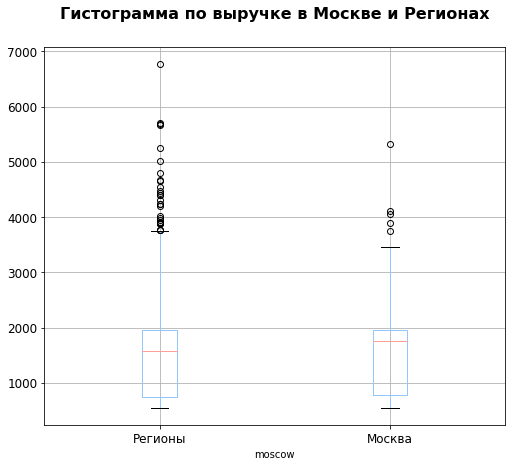

In [78]:
ax = df_numbers.boxplot(column='Сумма за месяц, руб.', by='moscow', fontsize=12, figsize=(8,7))

labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0] = 'Регионы'
labels[1] = 'Москва'

ax.set_xticklabels(labels)

plt.suptitle('Гистограмма по выручке в Москве и Регионах', fontsize=16, fontweight='bold')

ax.set_title('')
ax.title.set_size(40)

### Определим границы интервалов

In [79]:
region_get_iqr, moscow_get_iqr = get_iqr('Сумма за месяц, руб.', 'moscow')

Границы интервала для столбца "Сумма за месяц, руб." для регионов: 550.0 - 3750.0
Границы интервала для столбца "Сумма за месяц, руб." для Москвы: 550.0 - 3704.25


In [80]:
region_doxod = df_numbers[
    (df_numbers['Город'] != 'Москва') & (df_numbers['Сумма за месяц, руб.'] >= region_get_iqr[0])
    & (df_numbers['Сумма за месяц, руб.'] <= region_get_iqr[1])]['Сумма за месяц, руб.']
moscow_doxod = df_numbers[
    (df_numbers['Город'] == 'Москва') & (df_numbers['Сумма за месяц, руб.'] >= moscow_get_iqr[0])
    & (df_numbers['Сумма за месяц, руб.'] <= moscow_get_iqr[1])]['Сумма за месяц, руб.']

Расчет p-значения:

In [81]:
results = st.ttest_ind(region_doxod, moscow_doxod)
print('p-значение:', results.pvalue)

p-значение: 0.29404256281786206


In [82]:
alpha = 0.05
print('Пороговое значение alpha = 0.05')

Пороговое значение alpha = 0.05


In [83]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


### Верно утверждение, что средняя выручка пользователей из Москвы не отличается от выручки клиентов в Регионах. Посчитаем среднюю выручку по двум градациям.

In [84]:
print('Средняя выручка по пользователям для Регионов - {:.2f}'.format(region_doxod.mean()))
print('Средняя выручка по пользователям для Москвы - {:.2f}'.format(moscow_doxod.mean()))

Средняя выручка по пользователям для Регионов - 1489.67
Средняя выручка по пользователям для Москвы - 1524.60


### В Москве платят немного больше, чем в Регионах.

## 5. Общий вывод

### 5.1 Общие данные по использованию пакетов Смарт и Ультра

In [85]:
smart_mean_internet = (df_numbers[(df_numbers['Тариф'] == 'smart')]['Интернет, Гб']/(15)).mean()
print('Средн. процент использования пакета по интернету тарифа "Смарт" - {:.2%} = {:,.0f} Гб'.
      format(smart_mean_internet, smart_mean_internet * 15))
smart_mean_calls = (df_numbers[(df_numbers['Тариф'] == 'smart')]['Звонки, мин.']/(500)).mean()
print('Средн. процент использования пакета минут тарифа "Смарт" - {:.2%} = {:.2f} мин'.
      format(smart_mean_calls, smart_mean_calls * 500))
smart_mean_sms = (df_numbers[(df_numbers['Тариф'] == 'smart')]['СМС, шт.']/(50)).mean()
print('Средн. процент использования пакета СМС тарифа "Смарт" - {:.2%} = {:.0f} шт.'.
      format(smart_mean_sms, smart_mean_sms * 50))
ultra_mean_internet = (df_numbers[(df_numbers['Тариф'] == 'ultra')]['Интернет, Гб']/(30)).mean()
print('Средн. процент использования пакета по интернету тарифа "Ультра" - {:.2%} = {:,.0f} Гб'.
      format(ultra_mean_internet, ultra_mean_internet * 30))
ultra_mean_calls = (df_numbers[(df_numbers['Тариф'] == 'ultra')]['Звонки, мин.']/(3000)).mean()
print('Средн. процент использования пакета минут тарифа "Ультра" - {:.2%} = {:.2f} мин'.
      format(ultra_mean_calls, ultra_mean_calls * 3000))
ultra_mean_sms = (df_numbers[(df_numbers['Тариф'] == 'ultra')]['СМС, шт.']/(1000)).mean()
print('Средн. процент использования пакета СМС тарифа "Ультра" - {:.2%} = {:.0f} шт.'.
      format(ultra_mean_sms, ultra_mean_sms * 1000))

Средн. процент использования пакета по интернету тарифа "Смарт" - 108.86% = 16 Гб
Средн. процент использования пакета минут тарифа "Смарт" - 83.59% = 417.93 мин
Средн. процент использования пакета СМС тарифа "Смарт" - 66.77% = 33 шт.
Средн. процент использования пакета по интернету тарифа "Ультра" - 64.98% = 19 Гб
Средн. процент использования пакета минут тарифа "Ультра" - 17.55% = 526.62 мин
Средн. процент использования пакета СМС тарифа "Ультра" - 4.94% = 49 шт.


### 5.2 Общие данные по превышению пакетов Смарт и Ультра

In [86]:
smart_over_mean_internet = df_numbers[(df_numbers['Тариф'] == 'smart')]['Гб сверх'].mean()
smart_over_mean_internet_rub = smart_over_mean_internet * 200
print('Средн. превышение пакета по интернету по тарифа "Смарт" - {:.2f} Гб на сумму - {:.0f} руб.'.
      format(smart_over_mean_internet, smart_over_mean_internet_rub))

smart_over_mean_calls = np.ceil(df_numbers[(df_numbers['Тариф'] == 'smart')]['Минуты сверх'].mean())
smart_over_mean_calls_rub = smart_over_mean_calls * 3
print('Средн. превышение пакета минут тарифа "Смарт" - {:.0f} мин на сумму - {:.0f} руб.'.
      format(smart_over_mean_calls, smart_over_mean_calls_rub))

smart_over_mean_sms = np.ceil(df_numbers[(df_numbers['Тариф'] == 'smart')]['СМС сверх'].mean())
smart_over_mean_sms_rub = smart_over_mean_sms * 3
print('Средн. превышение пакета СМС тарифа "Смарт" - {:.0f} шт. на сумму - {:.0f} руб.'.
      format(smart_over_mean_sms, smart_over_mean_sms_rub))

ultra_over_mean_internet = df_numbers[(df_numbers['Тариф'] == 'ultra')]['Гб сверх'].mean()
ultra_over_mean_internet_rub = ultra_over_mean_internet * 150
print('Средн. превышение пакета по интернету тарифа "Ультра" - {:.2f} Гб на сумму - {:.0f} руб.'.
      format(ultra_over_mean_internet, ultra_over_mean_internet_rub))

ultra_over_mean_calls = np.ceil(df_numbers[(df_numbers['Тариф'] == 'ultra')]['Минуты сверх'].mean())
ultra_over_mean_calls_rub = ultra_over_mean_calls * 3
print('Средн. превышение пакета минут тарифа "Ультра" - {:.0f} мин на сумму - {:.0f} руб.'.
      format(ultra_over_mean_calls, ultra_over_mean_calls_rub))

ultra_over_mean_sms = np.ceil(df_numbers[(df_numbers['Тариф'] == 'ultra')]['СМС сверх'].mean())
ultra_over_mean_sms_rub = ultra_over_mean_sms * 3
print('Средн. превышение пакета СМС тарифа "Ультра" - {:.0f} шт. на сумму - {:.0f} руб.'.
      format(ultra_over_mean_sms, ultra_over_mean_sms_rub))

Средн. превышение пакета по интернету по тарифа "Смарт" - 2.99 Гб на сумму - 598 руб.
Средн. превышение пакета минут тарифа "Смарт" - 42 мин на сумму - 126 руб.
Средн. превышение пакета СМС тарифа "Смарт" - 6 шт. на сумму - 18 руб.
Средн. превышение пакета по интернету тарифа "Ультра" - 0.80 Гб на сумму - 120 руб.
Средн. превышение пакета минут тарифа "Ультра" - 0 мин на сумму - 0 руб.
Средн. превышение пакета СМС тарифа "Ультра" - 0 шт. на сумму - 0 руб.


### 5.3 Вывод

### Тариф  Смарт приносит около 60% всей выручки, но при этом на него приходится 2228 клиентов. Тариф Ультра дает остальные 40%, но эту выручку и это всего 984 клиентов.
### Клиентам тарифа Смарт не хватает в среднем 1,5 Гб интернета к заложенными в абонентскую плату 15 Гб и приходится до заказывать. Но в целом клиенты в средним осуществляют дополнительный заказа интернет-трафика в объеме 3 Гб, за которые они платят 600 рублей.

### Так как, в тариф Смарт более дешевый (бюджетный) за 550 рублей, где пользователю не хватает интернета и количество использованных минут разговора на грани лимита (418 мин из 500), а тариф Ультра, стоимостью 1950 рублей (тариф рассчитанный на другой класс клиентов и другой класс достатка), где по всем типам связи всего предостаточно (только иногда осуществляется дозаказ интернет-трафика на сумму 150 рублей - 1Гб).

### В целом нужно на рынок вывести еще альтернативный тарифный план для клиентов компании "Мегалайн", который был средним между тарифами Смарт и Ультра. Стоимостью 1150 руб (550+600), включено было 600-700 минут разговора, 100 сообщений и 20Гб интернет-трафика. И в перспективе через пару лет тариф Смарт закрыть, т.к. по нему клиенты готовы платить больше (и выходят за рамки услуг по нему), а так же поменяются другие экономические факторы с течением времени. 